In [1]:
import numpy as np
import scipy.interpolate as si
import matplotlib.pyplot as plt
import pandas as pd
from scipy.integrate import quad
from skfda.preprocessing.dim_reduction import FPCA
import torch
import torch.nn as nndata
import torch.optim as optim
from models_HLS import *
from data_generation_new import *
from utils import *
from training_HLS import *

In [2]:
J = 5
d =3000
phi1 = 0.5 * np.eye(J)
phi2 = np.zeros((J, J))
theta1 = 0.5 * np.eye(J)
theta2 = 0.5 * np.eye(J)
sigma = 1.0 / np.arange(1, J + 1)
X_coef, F_basis, fd_basis = generate_farma22_coef(d, J, Phi1=phi1, Phi2=phi2, Theta1=theta1, Theta2=theta2, Sigma=sigma, seed=10)
print(X_coef.shape)

norms of the basis are: [1. 1. 1. 1. 1.]
(3000, 5)


# Compute the true Long run covariance matrix on the Fourier Basis

In [3]:
center_dat_tensor = torch.tensor(X_coef, dtype=torch.float32)
center_dat_tensor.shape

torch.Size([3000, 5])

In [4]:
cov_weighted_true,_,_ =cov_l(center_dat_tensor , 0, round(d**(1/2)),  "Bartlett")
print((cov_weighted_true * 100).round() / 100)
sum(np.diag(cov_weighted_true))

tensor([[17.3100, -0.4900, -0.8700,  0.2300, -0.7000],
        [-0.4900,  3.5500,  0.5500,  0.4900, -0.0000],
        [-0.8700,  0.5500,  1.8000, -0.0500,  0.1000],
        [ 0.2300,  0.4900, -0.0500,  1.0400, -0.0300],
        [-0.7000, -0.0000,  0.1000, -0.0300,  0.5500]])


np.float32(24.25101)

# Conduct FPCA

In [5]:
print("NaNs in coef:", np.isnan(X_coef).any())
print("Infs in coef:", np.isinf(X_coef).any())
print("Max abs coef:", np.abs(X_coef).max())

NaNs in coef: False
Infs in coef: False
Max abs coef: 6.606481442110495


In [6]:
# Conduct FPCA
fpca_fbasis = FPCA(n_components=5)
fpca_fbasis.fit(fd_basis)
scores = fpca_fbasis.transform(fd_basis)

# Explained variance ratio
print("Explained variance by each PC:", fpca_fbasis.explained_variance_ratio_)
print(sum(fpca_fbasis.explained_variance_ratio_))

Explained variance by each PC: [0.68703072 0.16117977 0.07947682 0.04492458 0.02738811]
0.9999999999999999


/opt/anaconda3/envs/alex_env/lib/python3.10/site-packages/skfda/preprocessing/dim_reduction/_fpca.py:231: RuntimeWarning: divide by zero encountered in matmul
  final_matrix = X.coefficients @ np.transpose(l_inv_j_t)
/opt/anaconda3/envs/alex_env/lib/python3.10/site-packages/skfda/preprocessing/dim_reduction/_fpca.py:231: RuntimeWarning: overflow encountered in matmul
  final_matrix = X.coefficients @ np.transpose(l_inv_j_t)
/opt/anaconda3/envs/alex_env/lib/python3.10/site-packages/skfda/preprocessing/dim_reduction/_fpca.py:231: RuntimeWarning: invalid value encountered in matmul
  final_matrix = X.coefficients @ np.transpose(l_inv_j_t)
/opt/anaconda3/envs/alex_env/lib/python3.10/site-packages/skfda/preprocessing/dim_reduction/_fpca.py:281: RuntimeWarning: divide by zero encountered in matmul
  X.coefficients @ self._j_matrix
/opt/anaconda3/envs/alex_env/lib/python3.10/site-packages/skfda/preprocessing/dim_reduction/_fpca.py:281: RuntimeWarning: overflow encountered in matmul
  X.coeffi

In [7]:
E_coef = fpca_fbasis.components_.coefficients 
print(E_coef)
E_coef.shape

[[ 0.99988486  0.0113738  -0.00967383 -0.00250987  0.00100793]
 [-0.01130298  0.99975782  0.01060209 -0.01499312 -0.0043984 ]
 [ 0.00970577 -0.01046169  0.99877942 -0.01206019  0.0457227 ]
 [ 0.00265625  0.01399175  0.01892559  0.9883913  -0.15007213]
 [-0.00111651  0.00705136 -0.04330702  0.15068545  0.98760692]]


(5, 5)

In [8]:
# Compute the integral of each basis function over [0,1]
def basis_integral(j):
    """Compute the integral of the j-th basis function over [0,1]."""
    return quad(lambda s: F_basis(s)[j], 0, 1)[0]

I_j = np.array([basis_integral(j) for j in range(J)])

# Define beta coefficients (random or fixed values)
beta = np.random.randn(J)

# Compute Y
noise = np.random.normal(0, 1, size=d)
Y_np = np.sum(X_coef * beta * I_j, axis=1) + noise

In [9]:
Y_np.shape

(3000,)

In [10]:
scores.shape

(3000, 5)

In [11]:
center_dat = scores
center_dat.shape

(3000, 5)

In [12]:
df = pd.DataFrame(center_dat)
df.to_csv("center_dat_fspline.csv", index=False, header=False)

In [13]:
X = torch.tensor(center_dat, dtype=torch.float32) 
print(X.size())
Y = torch.tensor(Y_np, dtype=torch.float32).view(d, 1)
print(Y.size())

torch.Size([3000, 5])
torch.Size([3000, 1])


# Model adding covariates

In [14]:
# Parameters
porder = 0
band = round(d**(1/3)) # the bandwidth
print(band)

14


In [15]:
cov_weighted, cov_unweighted, cov_triple =cov_l(X, porder, band, kern_type = "Bartlett")
cov_weighted

tensor([[ 1.5313e+01, -8.9630e-02, -3.5170e-01,  6.2757e-03, -8.1656e-02],
        [-8.9630e-02,  3.3403e+00,  6.6305e-03,  1.6106e-01,  1.1571e-02],
        [-3.5170e-01,  6.6305e-03,  1.7237e+00, -2.4810e-02, -1.0189e-02],
        [ 6.2757e-03,  1.6106e-01, -2.4810e-02,  9.3147e-01, -3.9605e-02],
        [-8.1656e-02,  1.1571e-02, -1.0189e-02, -3.9605e-02,  5.6235e-01]])

In [16]:
cov_weighted_np = cov_weighted.detach().numpy()
cov_weighted_transform = E_coef.T @ cov_weighted_np @ E_coef
print("The estimated LR covariance matrix is:")
print(np.round(cov_weighted_transform,4))
print("The trace of the estimated LR covariance matrix is:")
print(sum(np.diag(cov_weighted_transform)))
print("The true LR covariance matrix is:")
print(np.round(cov_weighted_true.detach().numpy(),4))
print("The trace of the true LR covariance matrix is:")
print(sum(np.diag(cov_weighted_true)))

The estimated LR covariance matrix is:
[[15.306   0.0503 -0.4804 -0.0383 -0.0819]
 [ 0.0503  3.3436  0.0214  0.1241 -0.0275]
 [-0.4804  0.0214  1.7297 -0.0292  0.0448]
 [-0.0383  0.1241 -0.0292  0.9078 -0.0944]
 [-0.0819 -0.0275  0.0448 -0.0944  0.5842]]
The trace of the estimated LR covariance matrix is:
21.87127345800401
The true LR covariance matrix is:
[[ 1.73078e+01 -4.85000e-01 -8.68000e-01  2.27500e-01 -6.99100e-01]
 [-4.85000e-01  3.55440e+00  5.47800e-01  4.94000e-01 -1.90000e-03]
 [-8.68000e-01  5.47800e-01  1.79940e+00 -4.96000e-02  9.99000e-02]
 [ 2.27500e-01  4.94000e-01 -4.96000e-02  1.03820e+00 -3.27000e-02]
 [-6.99100e-01 -1.90000e-03  9.99000e-02 -3.27000e-02  5.51200e-01]]
The trace of the true LR covariance matrix is:
24.25101


Epoch [200/5000], Loss: 0.1882
Epoch [400/5000], Loss: 0.0064
Epoch [600/5000], Loss: 0.0003
Stopping early at Epoch [696/5000], Loss: 0.000099

Restoring best model weights...


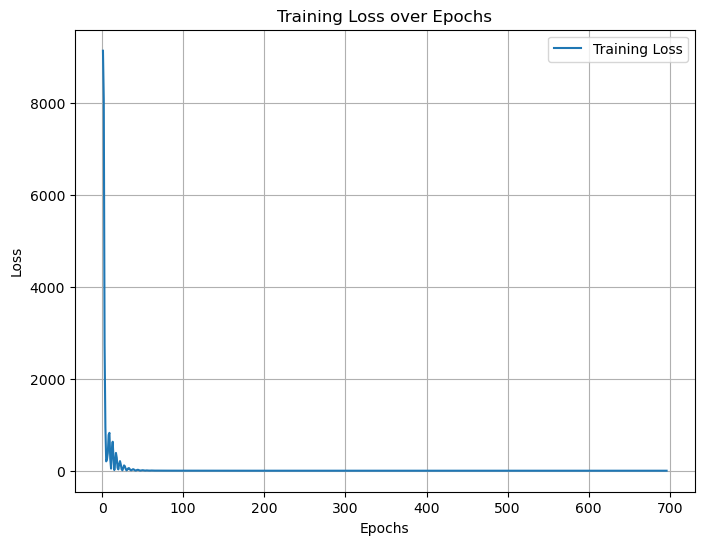

In [17]:
trained_model, losses, best_cov = train_model(
    X=X, Y=Y,
    ModelClass=Model1_new,
    porder=porder,
    band=band,
    kern_type= "Bartlett",
    hidden_dim=64,
    lr=0.01,
    epochs=5000,
    patience=300
)


Shape of Covariance Matrix (NumPy): (5, 5)


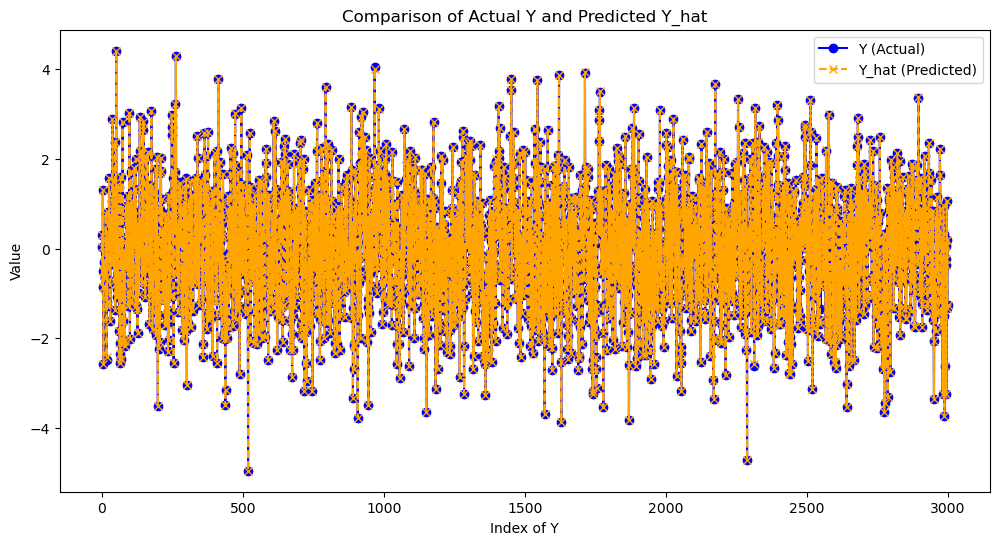

In [18]:
# Compute the best covariance matrix and predictions using the best model
with torch.no_grad():
    cov_weighted, cov_unweighted, cov_triple =cov_l(X, porder, band, kern_type = "Bartlett")
    cov_weighted_np = cov_weighted.cpu().numpy()  # Convert to NumPy

    # Print shape of the covariance matrix
    print("\nShape of Covariance Matrix (NumPy):", cov_weighted_np.shape)

    Y_hat = trained_model(X).view(-1).detach()  # Ensure Y_hat is flattened to match (d,)
    Y_actual = Y.view(-1).detach()  # Flatten Y to (d,)

# Plotting Y and Y_hat
plt.figure(figsize=(12, 6))
plt.plot(range(len(Y_actual)), Y_actual.cpu(), label='Y (Actual)', marker='o', linestyle='-', color='blue')
plt.plot(range(len(Y_hat)), Y_hat.cpu(), label='Y_hat (Predicted)', marker='x', linestyle='--', color='orange')

plt.xlabel("Index of Y")
plt.ylabel("Value")
plt.title("Comparison of Actual Y and Predicted Y_hat")
plt.legend()
plt.show()


# Compute true covariance matrix

In [19]:
N = 500
d_large = 100000
band = round(d_large ** (1 / 3))
kernel = "Bartlett"
filename = f"true_LRcov/empirical_cov_farma22_N{N}_d{d_large}_band{band}_kernel{kernel}.csv"
boostrap_true = np.loadtxt(filename, delimiter=",")

print(boostrap_true)

[[ 1.54033470e+01 -6.75036479e-03 -5.60570648e-03 -5.16102358e-04
  -2.91300967e-04]
 [-6.75036479e-03  3.83926153e+00 -5.89815085e-04  5.97011764e-04
  -2.35665496e-03]
 [-5.60570648e-03 -5.89815085e-04  1.70825708e+00  3.12268021e-05
   2.39152636e-04]
 [-5.16102358e-04  5.97011764e-04  3.12268021e-05  9.61562037e-01
   4.49809795e-06]
 [-2.91300967e-04 -2.35665496e-03  2.39152636e-04  4.49809795e-06
   6.15083277e-01]]


In [20]:
print("Sum of diagonal (boostrap cov matrix):",np.trace(boostrap_true))
print("Sum of diagonal (true cov matrix from data):", np.trace(cov_weighted_true))
print("Sum of diagonal (estimated cov matrix from kernel sandwich method):",np.trace(cov_weighted))
print("Sum of diagonal (estimated cov matrix with all weights =1):",np.trace(cov_unweighted))

Sum of diagonal (boostrap cov matrix): 22.527510941028595
Sum of diagonal (true cov matrix from data): 24.25101
Sum of diagonal (estimated cov matrix from kernel sandwich method): 21.871273
Sum of diagonal (estimated cov matrix with all weights =1): 26.554316


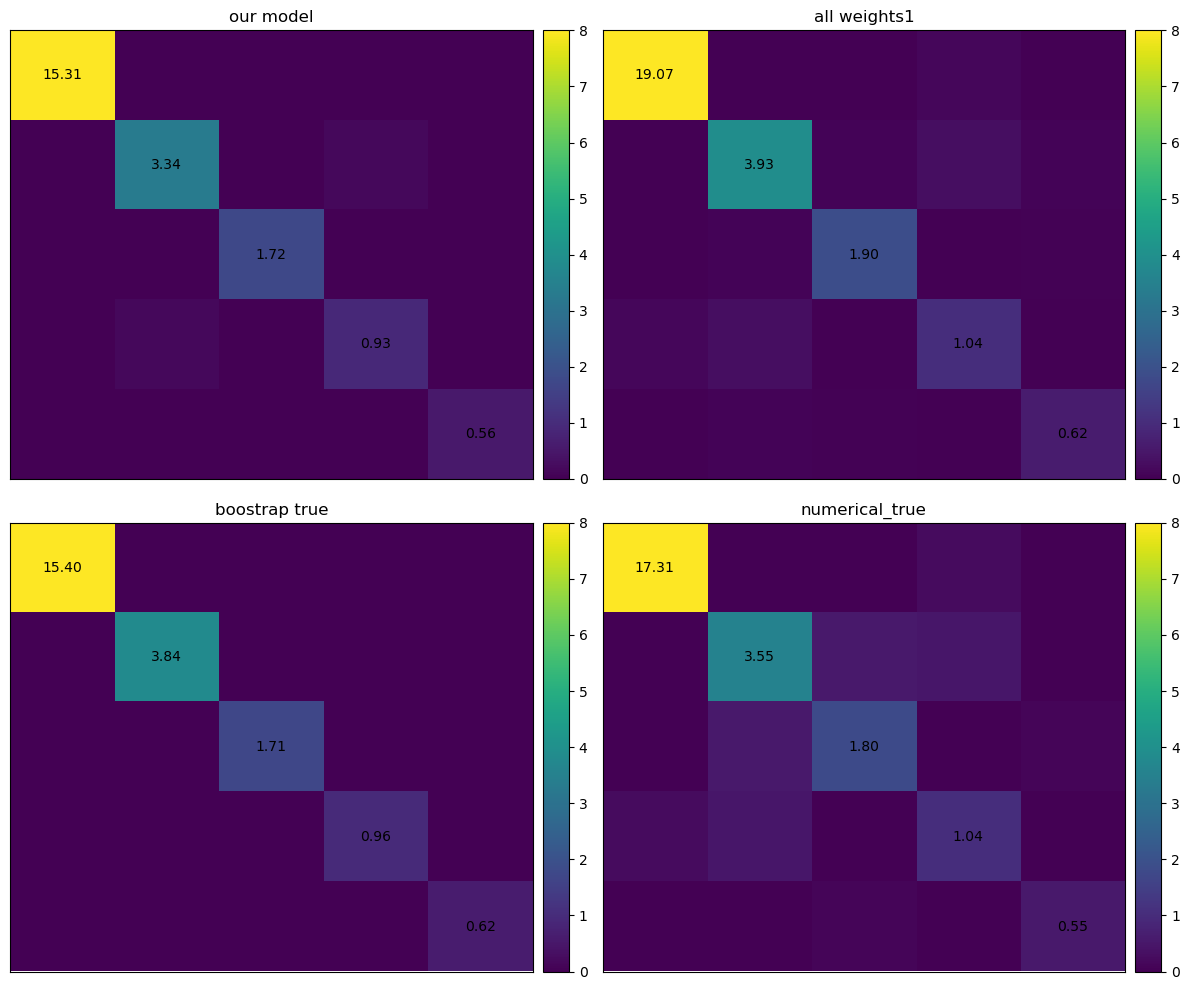

In [21]:
fig = plot_matrices_2d([cov_weighted,cov_unweighted, boostrap_true, cov_weighted_true], titles = ["our model", "all weights1", "boostrap true", "numerical_true"])